In [21]:
!pip install --quiet pdf2image
!apt-get install -y poppler-utils
!pip install --quiet fpdf

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Lambda, Concatenate, BatchNormalization, TimeDistributed, LSTM, Bidirectional
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ProgbarLogger
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image
from pdf2image import convert_from_path
from scipy.stats import skew, kurtosis
from datetime import datetime
from pathlib import Path

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.5).
0 upgraded, 0 newly installed, 0 to remove and 68 not upgraded.


In [3]:
np.random.seed(42)
tf.random.set_seed(42)


def load_data():
    train_data = pd.read_csv('/kaggle/input/emnist/emnist-letters-train.csv')
    X_train = train_data.iloc[:, 1:].values
    y_train = train_data.iloc[:, 0].values
    
    test_data = pd.read_csv('/kaggle/input/emnist/emnist-letters-test.csv')
    X_test = test_data.iloc[:, 1:].values
    y_test = test_data.iloc[:, 0].values
    
    X_train = X_train.reshape(-1, 28, 28, 1)
    X_test = X_test.reshape(-1, 28, 28, 1)
    
    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0
    
    return X_train, y_train, X_test, y_test


def create_model():
    input_shape = (28, 28, 1)
    inputs = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)
    
    x = Flatten()(x)
    x = Dense(512, activation='relu', name='forensic_dense')(x)
    x = Dropout(0.5)(x)

    outputs = Dense(26, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

def extract_forensic_features(model, image_batch):
    feature_model = Model(inputs=model.input, outputs=model.get_layer('forensic_dense').output)
    features = feature_model.predict(image_batch)
    return features

def compare_characters(model, char1, char2):
    feat1 = extract_forensic_features(model, char1.reshape(1, 28, 28, 1))
    feat2 = extract_forensic_features(model, char2.reshape(1, 28, 28, 1))
    similarity = np.dot(feat1, feat2.T) / (np.linalg.norm(feat1) * np.linalg.norm(feat2))
    return similarity[0][0]

def main():
    print("Loading data...")
    
    X_train, y_train, X_test, y_test = load_data()
    y_train = y_train - 1
    y_test = y_test - 1
    
    print("Creating model...")
    model = create_model()
    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    
    print("Training model...")
    history = model.fit(X_train, y_train,
                       batch_size=128,
                       epochs=10,  
                       validation_split=0.1,
                       verbose=1)
    
    print("\nEvaluating model...")
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test accuracy: {test_acc:.4f}")
    
    print("\nDemonstrating character comparison...")
    idx1, idx2 = np.random.randint(0, len(X_test), 2)
    similarity = compare_characters(model, X_test[idx1], X_test[idx2])
    print(f"Similarity score between test characters: {similarity:.4f}")
    print(f"True labels: {chr(65 + y_test[idx1])} and {chr(65 + y_test[idx2])}")
    
    return model, history

def analyze_character_features(model, character):
    features = extract_forensic_features(model, character.reshape(1, 28, 28, 1))

    feature_stats = {
        'mean': np.mean(features),
        'std': np.std(features),
        'max': np.max(features),
        'min': np.min(features)
    }
    return feature_stats

def batch_compare_characters(model, reference_char, comparison_chars):
    similarities = []
    for char in comparison_chars:
        sim = compare_characters(model, reference_char, char)
        similarities.append(sim)
    return np.array(similarities)


if __name__ == "__main__":
    print("Starting SigSense: The forensic handwriting analysis system...")
    model, history = main()

Starting SigSense: The forensic handwriting analysis system...
Loading data...
Creating model...
Training model...
Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.6027 - loss: 1.3139 - val_accuracy: 0.9258 - val_loss: 0.2247
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9042 - loss: 0.2910 - val_accuracy: 0.9373 - val_loss: 0.1923
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9255 - loss: 0.2230 - val_accuracy: 0.9439 - val_loss: 0.1726
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9341 - loss: 0.1970 - val_accuracy: 0.9437 - val_loss: 0.1760
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9370 - loss: 0.1827 - val_accuracy: 0.9456 - val_loss: 0.1723
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9402 - loss: 0.1699 - val_accuracy: 0.9464 - val_loss: 0.1637
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9442 - loss: 0.1581 - val_accuracy: 0.9482 

In [4]:

model, history = main()

Loading data...
Creating model...
Training model...
Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.6093 - loss: 1.2945 - val_accuracy: 0.9197 - val_loss: 0.2396
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9059 - loss: 0.2851 - val_accuracy: 0.9386 - val_loss: 0.1902
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9235 - loss: 0.2279 - val_accuracy: 0.9381 - val_loss: 0.1858
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9322 - loss: 0.2010 - val_accuracy: 0.9448 - val_loss: 0.1686
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9366 - loss: 0.1861 - val_accuracy: 0.9461 - val_loss: 0.1696
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9413 - loss: 0.1702 - val_accuracy: 0.9427 - val_loss: 0.1837
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9426 - loss: 0.1637 - val_accuracy: 0.9444 - val_loss: 0.1698
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 1

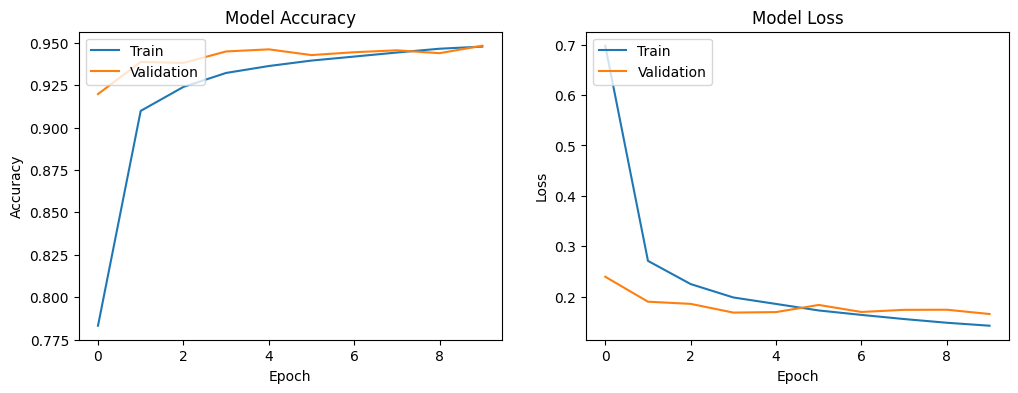

In [7]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    # Accuracy 
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Loss 
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.show()

plot_training_history(history)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


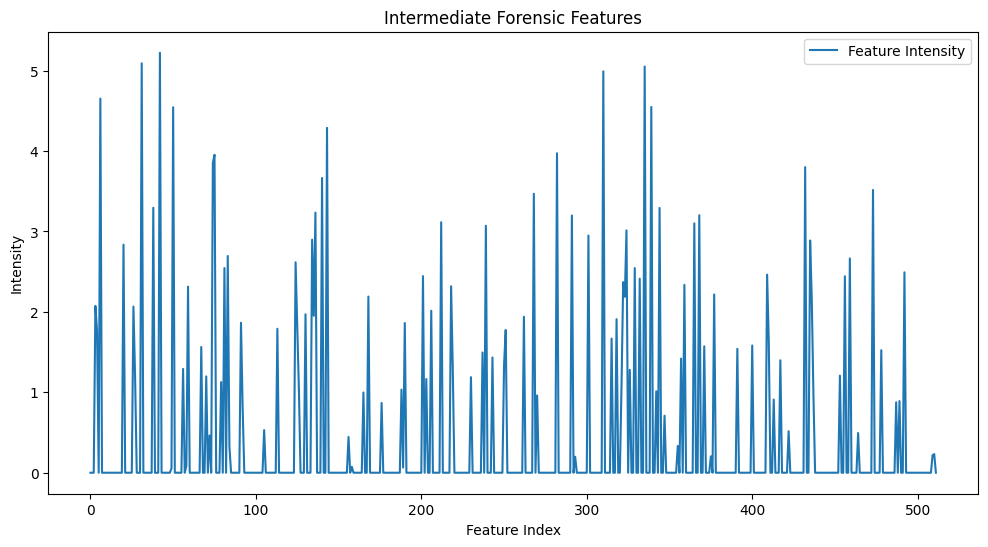

In [9]:
#intensity of single character
def visualize_features(features):
    plt.figure(figsize=(12, 6))
    plt.plot(features.flatten(), label="Feature Intensity")
    plt.xlabel("Feature Index")
    plt.ylabel("Intensity")
    plt.title("Intermediate Forensic Features")
    plt.legend()
    plt.show()

X_train, y_train, X_test, y_test = load_data()
features = extract_forensic_features(model, X_test[0].reshape(1, 28, 28, 1))
visualize_features(features)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


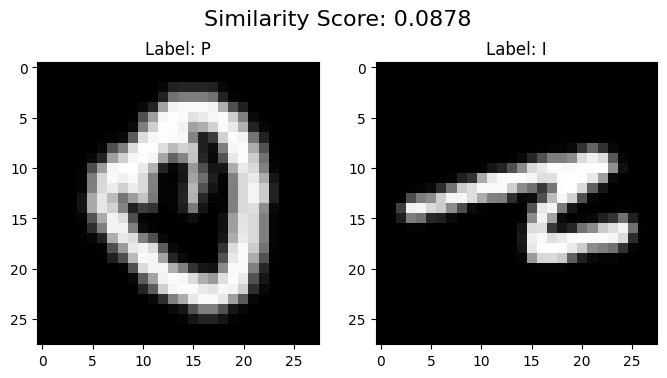

In [11]:

def visualize_comparison(X_test, y_test, idx1, idx2, similarity_score):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    
    axes[0].imshow(X_test[idx1].reshape(28, 28), cmap='gray')
    axes[0].set_title(f"Label: {chr(65 + y_test[idx1])}")
    
    axes[1].imshow(X_test[idx2].reshape(28, 28), cmap='gray')
    axes[1].set_title(f"Label: {chr(65 + y_test[idx2])}")
    
    plt.suptitle(f"Similarity Score: {similarity_score:.4f}", fontsize=16)
    plt.show()


idx1, idx2 = np.random.randint(0, len(X_test), 2)
similarity_score = compare_characters(model, X_test[idx1], X_test[idx2])
visualize_comparison(X_test, y_test, idx1, idx2, similarity_score)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

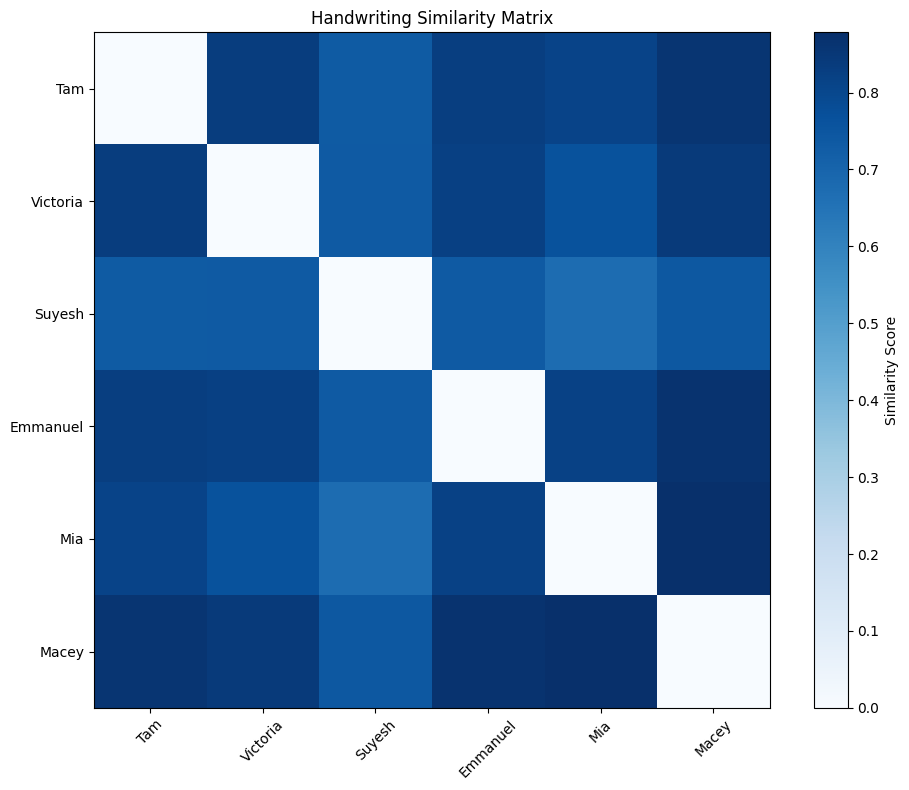


Detailed Comparison Results:

Tam's writing compared to:
  Victoria: 0.830
  Suyesh: 0.734
  Emmanuel: 0.830
  Mia: 0.810
  Macey: 0.861

Victoria's writing compared to:
  Tam: 0.830
  Suyesh: 0.737
  Emmanuel: 0.821
  Mia: 0.763
  Macey: 0.841

Suyesh's writing compared to:
  Tam: 0.734
  Victoria: 0.737
  Emmanuel: 0.735
  Mia: 0.675
  Macey: 0.744

Emmanuel's writing compared to:
  Tam: 0.830
  Victoria: 0.821
  Suyesh: 0.735
  Mia: 0.819
  Macey: 0.867

Mia's writing compared to:
  Tam: 0.810
  Victoria: 0.763
  Suyesh: 0.675
  Emmanuel: 0.819
  Macey: 0.878

Macey's writing compared to:
  Tam: 0.861
  Victoria: 0.841
  Suyesh: 0.744
  Emmanuel: 0.867
  Mia: 0.878


In [14]:

def extract_images_from_pdf(pdf_path, output_dir=None):
    try:
        images = convert_from_path(pdf_path)
        
        if output_dir:
            os.makedirs(output_dir, exist_ok=True)
            saved_paths = []
            for i, image in enumerate(images):
                image_path = os.path.join(output_dir, f'page_{i+1}.png')
                image.save(image_path, 'PNG')
                saved_paths.append(image_path)
            return saved_paths
        return images
    except Exception as e:
        print(f"Error processing PDF {pdf_path}: {str(e)}")
        return []

def process_writer_pdfs(base_dir):
    writer_samples = {}
    
    for writer_name in os.listdir(base_dir):
        writer_path = os.path.join(base_dir, writer_name)
        if os.path.isdir(writer_path):
            writer_samples[writer_name] = []
            
            for file_name in os.listdir(writer_path):
                if file_name.lower().endswith('.pdf'):
                    pdf_path = os.path.join(writer_path, file_name)
                    images = extract_images_from_pdf(pdf_path)
                    
                    for img in images:
                        img_gray = img.convert('L')
                        img_array = np.array(img_gray)
                        
                        img_resized = cv2.resize(img_array, (28, 28))
            
                        img_processed = img_resized.astype('float32') / 255.0
                        img_processed = img_processed.reshape(1, 28, 28, 1)
                        
                        writer_samples[writer_name].append(img_processed)
    
    return writer_samples

def compare_writers(model, writer_samples):
    results = {}
    
    for writer1 in writer_samples:
        results[writer1] = {}
        for writer2 in writer_samples:
            if writer1 != writer2:
                similarities = []
                
                for sample1 in writer_samples[writer1]:
                    for sample2 in writer_samples[writer2]:
                        similarity = compare_characters(model, sample1[0], sample2[0])
                        similarities.append(similarity)
                
                avg_similarity = np.mean(similarities) if similarities else 0
                results[writer1][writer2] = avg_similarity
    
    return results

def visualize_comparison_results(results):
    writers = list(results.keys())
    similarity_matrix = np.zeros((len(writers), len(writers)))
    
    for i, writer1 in enumerate(writers):
        for j, writer2 in enumerate(writers):
            if writer1 != writer2:
                similarity_matrix[i, j] = results[writer1][writer2]
    
    plt.figure(figsize=(10, 8))
    plt.imshow(similarity_matrix, cmap='Blues')
    plt.colorbar(label='Similarity Score')
    plt.xticks(range(len(writers)), writers, rotation=45)
    plt.yticks(range(len(writers)), writers)
    plt.title('Handwriting Similarity Matrix')
    plt.tight_layout()
    plt.show()

base_dir = "/kaggle/input/personalprofile"
writer_samples = process_writer_pdfs(base_dir)
comparison_results = compare_writers(model, writer_samples)
visualize_comparison_results(comparison_results)

print("\nDetailed Comparison Results:")
for writer1, comparisons in comparison_results.items():
    print(f"\n{writer1}'s writing compared to:")
    for writer2, similarity in comparisons.items():
        print(f"  {writer2}: {similarity:.3f}")

In [19]:
np.random.seed(42)
tf.random.set_seed(42)

class ForensicCharacterAnalyzer:
    def __init__(self):
        self.model = None

    def load_data(self):
        print("Loading data...")
        train_data = pd.read_csv('/kaggle/input/emnist/emnist-letters-train.csv')
        test_data = pd.read_csv('/kaggle/input/emnist/emnist-letters-test.csv')

        X_train = train_data.iloc[:, 1:].values.reshape(-1, 28, 28, 1).astype('float32') / 255.0
        y_train = train_data.iloc[:, 0].values - 1

        X_test = test_data.iloc[:, 1:].values.reshape(-1, 28, 28, 1).astype('float32') / 255.0
        y_test = test_data.iloc[:, 0].values - 1

        return X_train, y_train, X_test, y_test

    def create_model(self):
        input_shape = (28, 28, 1)
        inputs = Input(shape=input_shape)

        def create_stroke_features(x):
            sobel = tf.image.sobel_edges(x)
            sobel_x = sobel[..., 0]
            sobel_y = sobel[..., 1]
            angles = tf.math.atan2(sobel_y, sobel_x)
            magnitude = tf.sqrt(tf.square(sobel_x) + tf.square(sobel_y))
            angles = tf.expand_dims(tf.squeeze(angles, axis=-1), axis=-1)
            magnitude = tf.expand_dims(tf.squeeze(magnitude, axis=-1), axis=-1)
            return tf.concat([angles, magnitude], axis=-1)

        x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        x_main = MaxPooling2D((2, 2))(x)
        x_main = Dropout(0.25)(x_main)

        stroke_features = Lambda(create_stroke_features)(inputs)
        stroke_features = Conv2D(16, (3, 3), activation='relu', padding='same')(stroke_features)
        stroke_features = MaxPooling2D((2, 2))(stroke_features)

        x = Concatenate(axis=-1)([x_main, stroke_features])

        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2))(x)
        x = Dropout(0.25)(x)

        x = Flatten()(x)
        x = Dense(512, activation='relu', name='forensic_features')(x)
        x = Dropout(0.5)(x)

        outputs = Dense(26, activation='softmax')(x)

        self.model = Model(inputs=inputs, outputs=outputs)
        return self.model

    def analyze_stroke_characteristics(self, image):
        if isinstance(image, tf.Tensor):
            image = image.numpy()
        if len(image.shape) == 4:
            image = image[0]
        if len(image.shape) == 3:
            image = image[:, :, 0]
        img_uint8 = (image * 255).astype(np.uint8)

        edges = cv2.Canny(img_uint8, 50, 150)
        sobelx = cv2.Sobel(img_uint8, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(img_uint8, cv2.CV_64F, 0, 1, ksize=3)
        angles = np.arctan2(sobely, sobelx)
        magnitudes = np.sqrt(sobelx**2 + sobely**2)

        stroke_analysis = {
            'pressure_mean': np.mean(magnitudes),
            'pressure_std': np.std(magnitudes),
            'angle_mean': np.mean(angles),
            'angle_std': np.std(angles),
            'stroke_consistency': 1.0 / (np.std(magnitudes) + 1e-6),
            'edge_density': np.sum(edges > 0) / edges.size,
            'pressure_skew': skew(magnitudes.flatten()),
            'angle_distribution': np.histogram(angles.flatten(), bins=8)[0].tolist()
        }

        return stroke_analysis

    def extract_forensic_features(self, char_image):
        if self.model is None:
            raise ValueError("Model must be trained before extracting features")
        feature_model = Model(inputs=self.model.input, outputs=self.model.get_layer('forensic_features').output)
        features = feature_model.predict(char_image.reshape(1, 28, 28, 1))

        feature_stats = {
            'mean': np.mean(features),
            'std': np.std(features),
            'skewness': skew(features.flatten()),
            'kurtosis': kurtosis(features.flatten()),
            'quartiles': np.percentile(features, [25, 50, 75]).tolist(),
            'feature_vector': features.flatten()
        }

        return feature_stats

    def compare_characters(self, char1, char2):
        feat1_deep = self.extract_forensic_features(char1)
        feat2_deep = self.extract_forensic_features(char2)

        stroke1 = self.analyze_stroke_characteristics(char1)
        stroke2 = self.analyze_stroke_characteristics(char2)

        comparison = {
            'feature_similarity': self._cosine_similarity(feat1_deep['feature_vector'], feat2_deep['feature_vector']),
            'pressure_similarity': 1 - abs(stroke1['pressure_mean'] - stroke2['pressure_mean']) / max(stroke1['pressure_mean'], stroke2['pressure_mean']),
            'stroke_consistency_similarity': 1 - abs(stroke1['stroke_consistency'] - stroke2['stroke_consistency']) / max(stroke1['stroke_consistency'], stroke2['stroke_consistency']),
            'angle_similarity': self._compare_angle_distributions(stroke1['angle_distribution'], stroke2['angle_distribution'])
        }

        comparison['overall_similarity'] = (
            0.4 * comparison['feature_similarity'] +
            0.3 * comparison['pressure_similarity'] +
            0.2 * comparison['stroke_consistency_similarity'] +
            0.1 * comparison['angle_similarity']
        )

        return comparison

    def _cosine_similarity(self, v1, v2):
        return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

    def _compare_angle_distributions(self, dist1, dist2):
        dist1 = np.array(dist1) + 1e-10
        dist2 = np.array(dist2) + 1e-10
        dist1 /= np.sum(dist1)
        dist2 /= np.sum(dist2)
        m = 0.5 * (dist1 + dist2)
        js_div = 0.5 * (np.sum(dist1 * np.log(dist1 / m)) + np.sum(dist2 * np.log(dist2 / m)))
        return 1 / (1 + js_div)

def main():
    analyzer = ForensicCharacterAnalyzer()
    X_train, y_train, X_test, y_test = analyzer.load_data()
    model = analyzer.create_model()
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    print("Training model...")
    history = model.fit(X_train, y_train,
                        batch_size=128,
                        epochs=10,
                        validation_split=0.1,
                        verbose=1)

    print("\nPerforming forensic analysis on sample characters...")
    idx1, idx2 = np.random.randint(0, len(X_test), 2)
    comparison = analyzer.compare_characters(X_test[idx1], X_test[idx2])

    print("\nForensic Comparison Results:")
    for metric, value in comparison.items():
        print(f"{metric}: {value:.4f}")

    return analyzer, history

if __name__ == "__main__":
    analyzer, history = main()


Loading data...
Training model...
Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.6741 - loss: 1.0898 - val_accuracy: 0.9126 - val_loss: 0.2632
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8926 - loss: 0.3258 - val_accuracy: 0.9312 - val_loss: 0.2140
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9133 - loss: 0.2586 - val_accuracy: 0.9363 - val_loss: 0.1935
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9245 - loss: 0.2213 - val_accuracy: 0.9399 - val_loss: 0.1934
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9292 - loss: 0.2017 - val_accuracy: 0.9414 - val_loss: 0.1862
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9352 - loss: 0.1841 - val_accuracy: 0.9420 - val_loss: 0.1854
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9389 - loss: 0.1708 - val_accuracy: 0.9456 - val_loss: 0.1811
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.94

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.6799 - loss: 1.0740 - val_accuracy: 0.9164 - val_loss: 0.2591
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8937 - loss: 0.3235 - val_accuracy: 0.9295 - val_loss: 0.2199
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9152 - loss: 0.2534 - val_accuracy: 0.9337 - val_loss: 0.2012
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9238 - loss: 0.2234 - val_accuracy: 0.9402 - val_loss: 0.1865
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9314 - loss: 0.1990 - val_accuracy: 0.9409 - val_loss: 0.1881
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9350 - loss: 0.1823 - val_accuracy: 0.9414 - val_loss: 0.1881
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9380 - loss: 0.1716 - val_accuracy: 0.9421 - val_loss: 0.1869
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


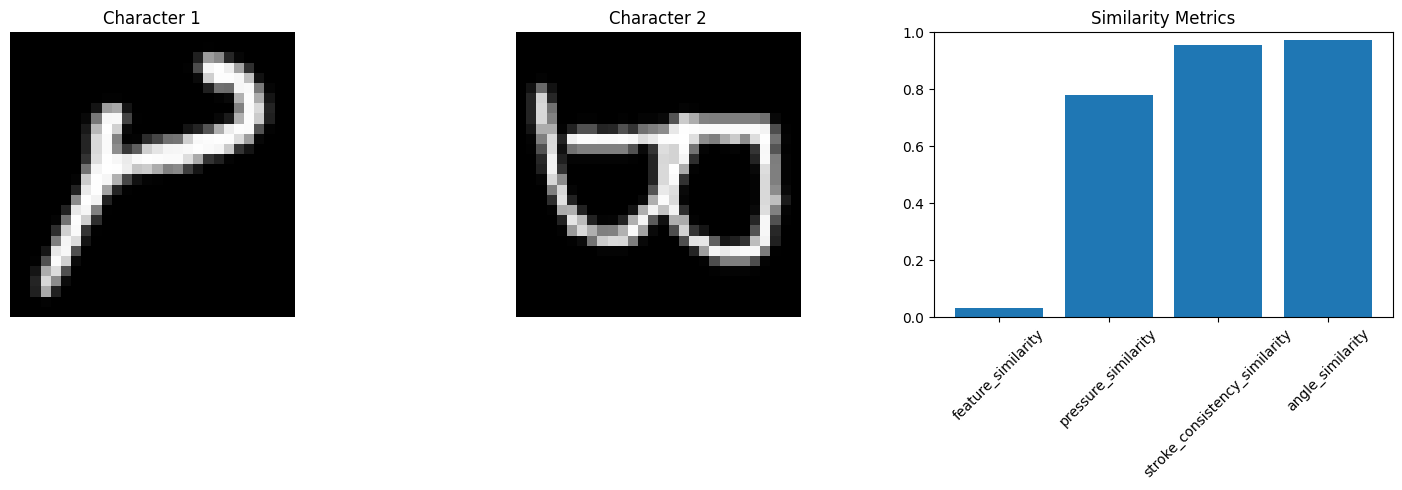

In [22]:
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

np.random.seed(42)
tf.random.set_seed(42)

class ForensicCharacterAnalyzer:
    def __init__(self, model_path=None):
        self.model = None
        if model_path:
            self.load_model(model_path)
            

    def load_data(self, train_path=None, test_path=None):
        try:
            train_path = train_path or '/kaggle/input/emnist/emnist-letters-train.csv'
            test_path = test_path or '/kaggle/input/emnist/emnist-letters-test.csv'

            if not os.path.exists(train_path) or not os.path.exists(test_path):
                raise FileNotFoundError(f"Dataset files not found at {train_path} or {test_path}")

            logger.info("Loading training data...")
            train_data = pd.read_csv(train_path)
            
            logger.info("Loading test data...")
            test_data = pd.read_csv(test_path)

            X_train = train_data.iloc[:, 1:].values.reshape(-1, 28, 28, 1).astype('float32') / 255.0
            y_train = train_data.iloc[:, 0].values - 1  

            X_test = test_data.iloc[:, 1:].values.reshape(-1, 28, 28, 1).astype('float32') / 255.0
            y_test = test_data.iloc[:, 0].values - 1

            logger.info(f"Data loaded successfully. Training samples: {len(X_train)}, Test samples: {len(X_test)}")
            return X_train, y_train, X_test, y_test

        except Exception as e:
            logger.error(f"Error loading data: {str(e)}")
            raise

    def create_model(self):
        try:
            input_shape = (28, 28, 1)
            inputs = Input(shape=input_shape)

            def create_stroke_features(x):
                sobel = tf.image.sobel_edges(x)
                sobel_x = sobel[..., 0]
                sobel_y = sobel[..., 1]
                angles = tf.math.atan2(sobel_y, sobel_x)
                magnitude = tf.sqrt(tf.square(sobel_x) + tf.square(sobel_y))
                angles = tf.expand_dims(tf.squeeze(angles, axis=-1), axis=-1)
                magnitude = tf.expand_dims(tf.squeeze(magnitude, axis=-1), axis=-1)
                return tf.concat([angles, magnitude], axis=-1)

            x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
            x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
            x_main = MaxPooling2D((2, 2))(x)
            x_main = Dropout(0.25)(x_main)

            stroke_features = Lambda(create_stroke_features)(inputs)
            stroke_features = Conv2D(16, (3, 3), activation='relu', padding='same')(stroke_features)
            stroke_features = MaxPooling2D((2, 2))(stroke_features)

            x = Concatenate(axis=-1)([x_main, stroke_features])

            x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
            x = MaxPooling2D((2, 2))(x)
            x = Dropout(0.25)(x)

            x = Flatten()(x)
            x = Dense(512, activation='relu', name='forensic_features')(x)
            x = Dropout(0.5)(x)
            outputs = Dense(26, activation='softmax')(x)

            self.model = Model(inputs=inputs, outputs=outputs)
            logger.info("Model created successfully")
            return self.model

        except Exception as e:
            logger.error(f"Error creating model: {str(e)}")
            raise

    def analyze_stroke_characteristics(self, image):
        if image is None:
            raise ValueError("Input image cannot be None")
            
        if not isinstance(image, (np.ndarray, tf.Tensor)):
            raise TypeError("Image must be either numpy array or tensorflow tensor")

        try:
            # Convert and normalize image
            if isinstance(image, tf.Tensor):
                image = image.numpy()
            if len(image.shape) == 4:
                image = image[0]
            if len(image.shape) == 3:
                image = image[:, :, 0]

            img_uint8 = (image * 255).astype(np.uint8)

            edges = cv2.Canny(img_uint8, 50, 150)
            sobelx = cv2.Sobel(img_uint8, cv2.CV_64F, 1, 0, ksize=3)
            sobely = cv2.Sobel(img_uint8, cv2.CV_64F, 0, 1, ksize=3)
            angles = np.arctan2(sobely, sobelx)
            magnitudes = np.sqrt(sobelx**2 + sobely**2)

            return {
                'pressure_mean': np.mean(magnitudes),
                'pressure_std': np.std(magnitudes),
                'angle_mean': np.mean(angles),
                'angle_std': np.std(angles),
                'stroke_consistency': 1.0 / (np.std(magnitudes) + 1e-6),
                'edge_density': np.sum(edges > 0) / edges.size,
                'pressure_skew': skew(magnitudes.flatten()),
                'angle_distribution': np.histogram(angles.flatten(), bins=8)[0].tolist()
            }

        except Exception as e:
            logger.error(f"Error in stroke analysis: {str(e)}")
            raise

    def extract_forensic_features(self, char_image):
        if self.model is None:
            raise ValueError("Model must be trained before extracting features")

        try:
            feature_model = Model(
                inputs=self.model.input,
                outputs=self.model.get_layer('forensic_features').output
            )
            features = feature_model.predict(char_image.reshape(1, 28, 28, 1))

            return {
                'mean': np.mean(features),
                'std': np.std(features),
                'skewness': skew(features.flatten()),
                'kurtosis': kurtosis(features.flatten()),
                'quartiles': np.percentile(features, [25, 50, 75]).tolist(),
                'feature_vector': features.flatten()
            }

        except Exception as e:
            logger.error(f"Error extracting features: {str(e)}")
            raise

    def compare_characters(self, char1, char2):
        try:
            feat1_deep = self.extract_forensic_features(char1)
            feat2_deep = self.extract_forensic_features(char2)

            stroke1 = self.analyze_stroke_characteristics(char1)
            stroke2 = self.analyze_stroke_characteristics(char2)

            comparison = {
                'feature_similarity': self._cosine_similarity(
                    feat1_deep['feature_vector'],
                    feat2_deep['feature_vector']
                ),
                'pressure_similarity': 1 - abs(
                    stroke1['pressure_mean'] - stroke2['pressure_mean']
                ) / max(stroke1['pressure_mean'], stroke2['pressure_mean']),
                'stroke_consistency_similarity': 1 - abs(
                    stroke1['stroke_consistency'] - stroke2['stroke_consistency']
                ) / max(stroke1['stroke_consistency'], stroke2['stroke_consistency']),
                'angle_similarity': self._compare_distributions(
                    stroke1['angle_distribution'],
                    stroke2['angle_distribution']
                )
            }

            comparison['overall_similarity'] = (
                0.4 * comparison['feature_similarity'] +
                0.3 * comparison['pressure_similarity'] +
                0.2 * comparison['stroke_consistency_similarity'] +
                0.1 * comparison['angle_similarity']
            )

            return comparison

        except Exception as e:
            logger.error(f"Error comparing characters: {str(e)}")
            raise

    def visualize_comparison(self, char1, char2, comparison_results):
        try:
            plt.figure(figsize=(15, 5))
            
            plt.subplot(131)
            plt.imshow(char1.reshape(28, 28), cmap='gray')
            plt.title('Character 1')
            plt.axis('off')
            
            plt.subplot(132)
            plt.imshow(char2.reshape(28, 28), cmap='gray')
            plt.title('Character 2')
            plt.axis('off')
            
            plt.subplot(133)
            metrics = [k for k in comparison_results.keys() if k != 'overall_similarity']
            values = [comparison_results[k] for k in metrics]
            
            plt.bar(range(len(metrics)), values)
            plt.xticks(range(len(metrics)), metrics, rotation=45)
            plt.title('Similarity Metrics')
            plt.ylim(0, 1)
            
            plt.tight_layout()
            return plt.gcf()

        except Exception as e:
            logger.error(f"Error visualizing comparison: {str(e)}")
            raise

    def save_model(self, path):
        if self.model is None:
            raise ValueError("No model to save")
            
        if not path.endswith('.keras'):
            path = path.rsplit('.', 1)[0] + '.keras'
            
        try:
            self.model.save(path)
            logger.info(f"Model saved successfully to {path}")
        except Exception as e:
            logger.error(f"Error saving model: {str(e)}")
            raise
    def load_model(self, path):
        if not os.path.exists(path):
            raise FileNotFoundError(f"Model file not found at {path}")
            
        try:
            self.model = tf.keras.models.load_model(path)
            logger.info(f"Model loaded successfully from {path}")
        except Exception as e:
            logger.error(f"Error loading model: {str(e)}")
            raise

    def _cosine_similarity(self, v1, v2):
        return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

    def _compare_distributions(self, dist1, dist2):
        dist1 = np.array(dist1) + 1e-10
        dist2 = np.array(dist2) + 1e-10
        dist1 /= np.sum(dist1)
        dist2 /= np.sum(dist2)
        m = 0.5 * (dist1 + dist2)
        js_div = 0.5 * (np.sum(dist1 * np.log(dist1 / m)) + np.sum(dist2 * np.log(dist2 / m)))
        return 1 / (1 + js_div)

def main():
    logger.info("Initializing Forensic Character Analyzer...")

    output_dir = Path("forensic_analysis_results")
    output_dir.mkdir(exist_ok=True)
    
    try:
        analyzer = ForensicCharacterAnalyzer()
        X_train, y_train, X_test, y_test = analyzer.load_data()
        model = analyzer.create_model()
        
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        logger.info("Model compiled successfully")
        
        callbacks = [
            ModelCheckpoint(
                str(output_dir / "best_model.keras"),
                save_best_only=True,
                monitor='val_accuracy'
            ),
            EarlyStopping(
                monitor='val_loss',
                patience=3,
                restore_best_weights=True
            ),
        ]

        logger.info("Starting model training...")
        history = model.fit(
            X_train, y_train,
            batch_size=128,
            epochs=10,
            validation_split=0.1,
            callbacks=callbacks,
            verbose=1
        )
        
        analyzer.save_model(str(output_dir / "final_model.h5"))
        test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
        logger.info(f"Test accuracy: {test_acc:.4f}")
        
        logger.info("Performing sample character comparison...")
        idx1, idx2 = np.random.randint(0, len(X_test), 2)
        comparison = analyzer.compare_characters(X_test[idx1], X_test[idx2])
        
        fig = analyzer.visualize_comparison(X_test[idx1], X_test[idx2], comparison)
        fig.savefig(str(output_dir / "sample_comparison.png"))
        
        logger.info("Analysis completed successfully")
        return analyzer, history

    except Exception as e:
        logger.error(f"Error in main execution: {str(e)}")
        raise

if __name__ == "__main__":
    analyzer, history = main()